In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from scipy.sparse.csr import csr_matrix
from scipy import stats, integrate
sns.set(color_codes=True)
%matplotlib inline

# `1 Propensity score matching`

In [2]:
data = pd.read_csv('lalonde.csv')
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## `(1)(1) A Naive Analysis`

**Basic Stats**

In [3]:
treated = data[data.treat==1]
untreated = data[data.treat==0]
re78_treated = treated["re78"]
re78_untreated = untreated["re78"]

In [4]:
treated_ratio = int(re78_treated.count()/(re78_untreated.count()+ re78_treated.count()) * 100)
print("Ratio of treated people = " + str(treated_ratio) + "%")

Ratio of treated people = 30%


We see that out of the 614 samples, there is only 185 samples (30%) who are treated (did the the job traning program).

**Kolmogorov–Smirnov Test**

The k-s test returns a D statistic and a p-value corresponding to the D statistic. The D statistic is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution.

The p-value returned by the k-s test has the same interpretation as other p-values. You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level.

In [5]:
stats.ks_2samp(re78_treated, re78_untreated)

Ks_2sampResult(statistic=0.098607698607698691, pvalue=0.15279452288468109)

$p-value \geqslant 0.05$ so, we can't reject the null hypothesis meanig that there is a difference betwen distribtuion of the variable 're78' between two groups. Let's see what kind of differnece is this.

Note that we consider the significant level for p-value to be approximately 0.05.

**Visual Comparison**

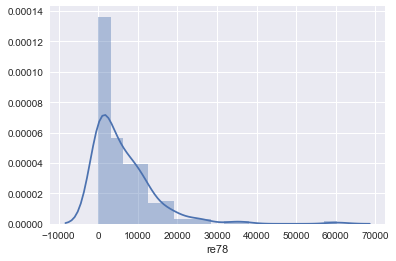

In [6]:
sns.distplot(re78_treated)

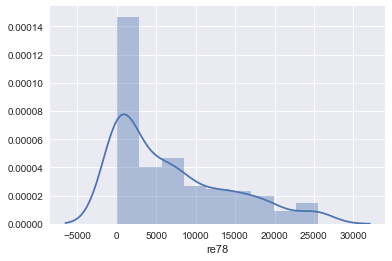

In [7]:
sns.distplot(re78_untreated)

In [8]:
re78_untreated.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [9]:
re78_treated.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

From these plots and the stats, it seems that the income of untreated group is higher meaning that the **treatment is not effective**.

In addition to what is asked in the question, wanted to analyze the distribution of variables (not only 're78') in general to have a better understanding of the effectiveness of the treatment.

In [10]:
def compare_distributions(s1, s2, feature, title):
    plt.figure(figsize = (10,8))
    plt.hist([s1[feature], s2[feature]], edgecolor='k', stacked= False)
    plt.legend(['No Treatment','Treatment'])
    plt.title('Treated, Untreated subjects by ' + title)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
    print("Satistics of Untreated subjects by " + title + "\n")
    print(s1[feature].describe())
    print("\n\nSatistics of Treated subjects by " + title + "\n")
    print(s2[feature].describe())

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


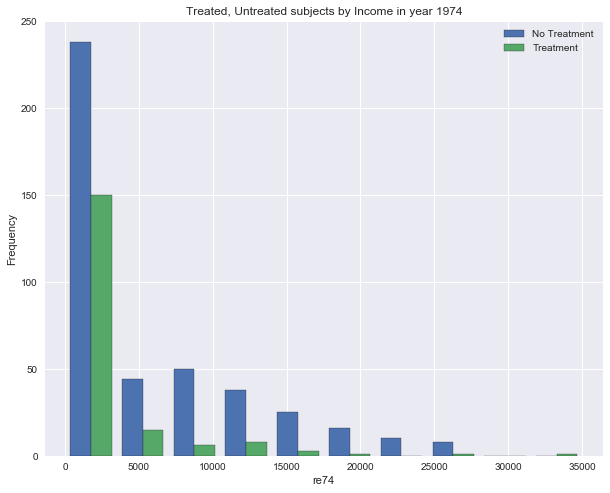

Satistics of Untreated subjects by Income in year 1974

count      429.000000
mean      5619.236506
std       6788.750796
min          0.000000
25%          0.000000
50%       2547.047000
75%       9277.128000
max      25862.320000
Name: re74, dtype: float64


Satistics of Treated subjects by Income in year 1974

count      185.000000
mean      2095.573689
std       4886.620353
min          0.000000
25%          0.000000
50%          0.000000
75%       1291.468000
max      35040.070000
Name: re74, dtype: float64


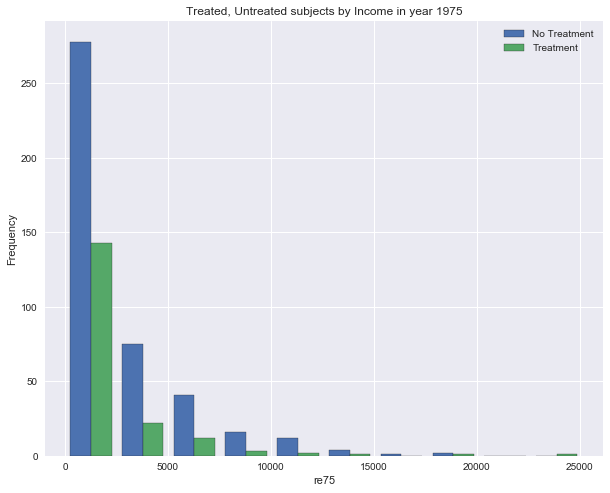

Satistics of Untreated subjects by Income in year 1975

count      429.000000
mean      2466.484443
std       3291.996183
min          0.000000
25%          0.000000
50%       1086.726000
75%       3881.419000
max      18347.230000
Name: re75, dtype: float64


Satistics of Treated subjects by Income in year 1975

count      185.000000
mean      1532.055314
std       3219.250870
min          0.000000
25%          0.000000
50%          0.000000
75%       1817.284000
max      25142.240000
Name: re75, dtype: float64


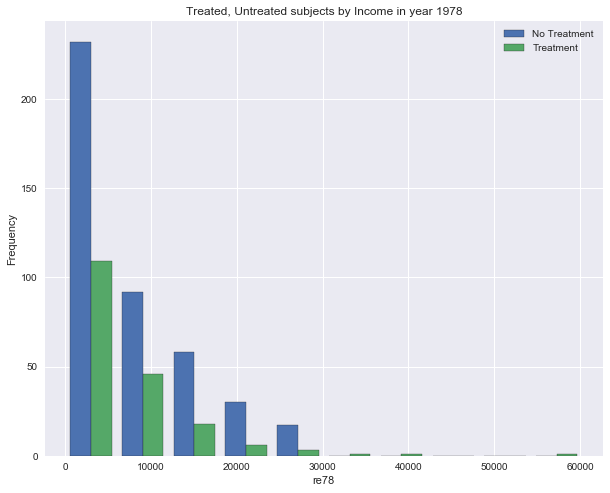

Satistics of Untreated subjects by Income in year 1978

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64


Satistics of Treated subjects by Income in year 1978

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


In [11]:
year_variables = ['re74','re75','re78']
for year in year_variables:
    title = 'Income in year 19{}'.format(year[2:])
    compare_distributions(untreated, treated, year, title)

Again, it seems that what the naive method says is that the treatment is **ineffective**.

## `(1)(2) A Closer Look at the Data `

We now compare the distribution of each feature in the treated group with its distribution in the untreated group.

### `Comparison by Age`

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


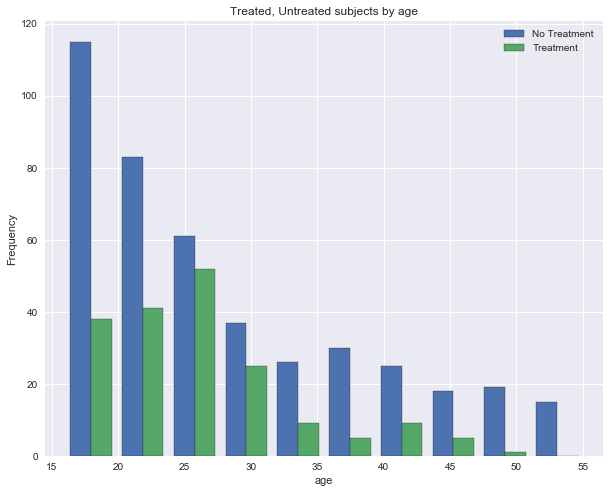

Satistics of Untreated subjects by age

count    429.000000
mean      28.030303
std       10.786653
min       16.000000
25%       19.000000
50%       25.000000
75%       35.000000
max       55.000000
Name: age, dtype: float64


Satistics of Treated subjects by age

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64


In [12]:
compare_distributions(untreated, treated, 'age', 'age')

In [13]:
age_treated = data[data.treat==1]["age"]
age_untreated = data[data.treat==0]["age"]

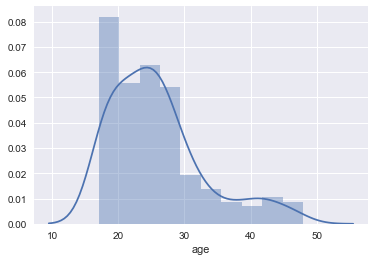

In [14]:
sns.distplot(age_treated)

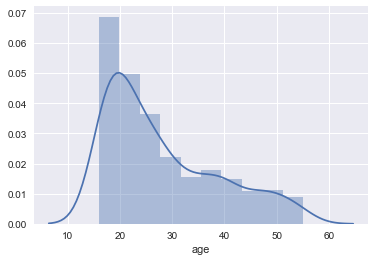

In [15]:
sns.distplot(age_untreated)

In [16]:
stats.ks_2samp(age_treated, age_untreated)

Ks_2sampResult(statistic=0.15772695772695777, pvalue=0.0027787486444449967)

$p-value \leqslant 0.05$ so, we reject the null hypothesis meanig that there is no difference betwen distribtuion of the variable 'age' between two groups. This is what we also observed on figures.

### `Comparison by Education`

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


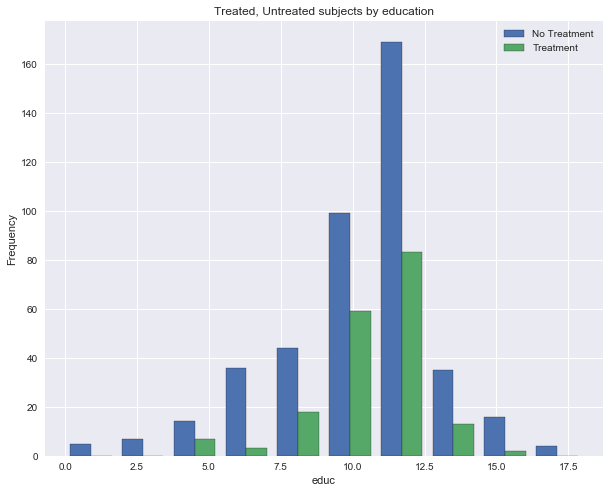

Satistics of Untreated subjects by education

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64


Satistics of Treated subjects by education

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64


In [17]:
compare_distributions(untreated, treated, 'educ', 'education')

Treatment/non treament by education is normally distributed with a small negative skew.

In [18]:
educ_treated = data[data.treat==1]["educ"]
educ_untreated = data[data.treat==0]["educ"]

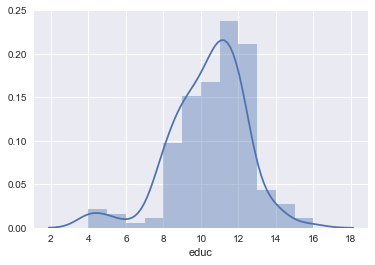

In [19]:
sns.distplot(educ_treated)

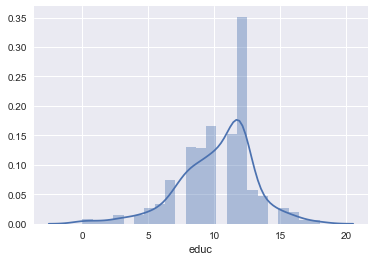

In [20]:
sns.distplot(educ_untreated)

In [21]:
stats.ks_2samp(educ_treated, educ_untreated)

Ks_2sampResult(statistic=0.11137151137151136, pvalue=0.075243451787299645)

p-value is very close to 0.05$ so, it is reasonable to reject the null hypothesis meanig that there is no difference betwen distribtuion of the variable 'educ' between two groups. This is also, what we observed from figures.

### `Comparison by Skin Color, Marital Status and Having Degree`

For the categorical (0/1) features ***race (black and hispanic), married & nondegree***, we will sum up the value of those features to get the count. 

In [22]:
def ratios(data , features):
    ones = []
    zeros = []
    for f in features:
        one = (data[f].values.sum()/data[f].count())*100
        zero = 100 - one
        ones.append(one)
        zeros.append(zero)
    return ones, zeros

In [23]:
def compare_feature_value(treated, untreated):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    features = ['black', 'hispan', 'married', 'nodegree']
    ones, zeros = ratios(treated, features)
    n = [0, 1, 2, 3]
    title = 'treated subjects'
    data = [treated, untreated]
    for i in range(2):
        ones, zeros = ratios(data[i], features)
        if (i == 1):
            title = 'Un' + title
        plt.sca(ax[i])
        plt.xticks(n, features)
        plt.ylabel('Percentage of ' + title )
        plt.yticks( [0, 25, 50, 75, 100] )
        plt.bar(n, ones)
        plt.bar(n, zeros, bottom = ones)
        plt.title('Feature-wise ' + title)
        plt.legend(('1','0'))

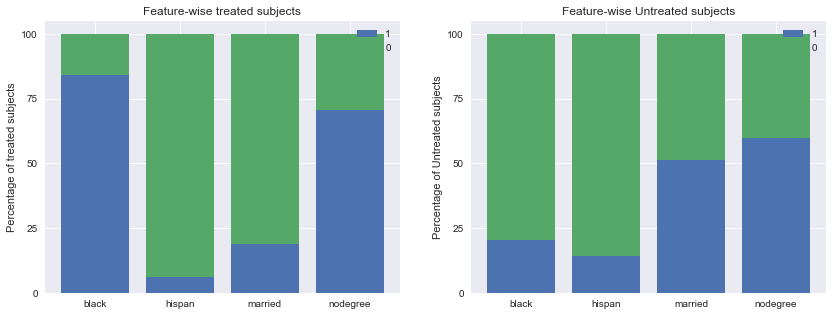

In [24]:
compare_feature_value(treated, untreated)

As it is seen from these figures, the frequency of black skin colored people is much higher in untreated subjects. And in terms of marital status, the frequency of married people is higher among untreated subjects.
The frequecny of hispanic people and people who have a degree is similar between groups.

Overall, by naive analysis we can conclude that education level, age, having degree, being an hispanic people  is similar between treated and untreated groups. Yet, the income level in 1978 is similar which means that again, the treatment is **ineffective** even after examining different variables.

## `(1)(3) A Propensity Score Model`

Let us train our data to estimate the propensity score for each datapoint, i.e the probability of being treated (or not).

In [25]:
dataV2 = pd.read_csv('lalonde.csv', index_col=0)
logistic = linear_model.LogisticRegression()
Z = dataV2['treat']
X = dataV2.drop('treat', axis=1)
logistic.fit(X,Z)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Once our data is trained, we now calculate the propensity scores:

In [26]:
score = logistic.predict_proba(X)
score_lalonde = dataV2.copy()
score_lalonde["prop_0"] = score[:,0]
score_lalonde["prop_1"] = score[:,1]
score_lalonde.head(10)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_0,prop_1
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.541926,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.848020,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.249034,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.325980,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.329410,0.670590
NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0.288746,0.711254
NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0.350384,0.649616
NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0.339566,0.660434
NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0.416180,0.583820


## `(1)(4) Balancing the Dataset via Matching`

Now that we got our scores, let us split our dataframe into 2 groups as we did earlier: the treated group, and the control (untreated) group:

In [27]:
score_treated = score_lalonde[score_lalonde['treat'] == 1]
score_untreated = score_lalonde[score_lalonde['treat'] == 0]

In [28]:
A = score_treated.index
B = score_untreated.index

We will now match each data point from the treated group with exactly one data point from the control group.
In order to do that we first create a **Bipartite Graph G connecting all the points from the two groups**, and then extract a **one-to-one mapping** minimizing the sum of costs over all the edges.

We will now use the **Python networkx package** in order to construct a **Bipartite Graph G** consisting of **sets of vertices A & B**. Each *vertex* represent a datapoint in X, and each *edge* has a weight w. 
1. Let **A** be the set of all vertices consisting of propensity scores relative the treated group **(treat=1)**
2. Let **B** be the set of all vertices consisting of propensity scores relative the untreated group **(treat=0)**
3. We define the *weight* **w** of each edge **E = (Ai, Bj)** as the absolute value difference of the scores of the vertices **Ai** & **Bj**

In [29]:
import networkx as nx
from networkx.algorithms import bipartite

We now construct the vertices by mapping every element of A to every element of B

In [30]:
G = nx.Graph()
G.add_nodes_from(A, bipartite=0)
G.add_nodes_from(B, bipartite=1)

for i in A:
    for j in B:
        G.add_edge(i,j, weight= - abs(score_treated.loc[i].prop_1 - score_untreated.loc[j].prop_1))

Next, we should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.


**N.B: Since the networkx package only offers a maximization function, we put a minus sign in front of the absolute value weight of our edges.** This way, we shall **maximize the opposite of the sum of scores**, which is *equivalent* to the problem of **minimizing the sum of scores.**  




In [31]:
match = nx.max_weight_matching(G, maxcardinality= True)

In [32]:
len(match)/2

185.0

We see that all the matches appears twice (for each edge (Ai, Bj) there is a corresponding one (Bj, Ai)), which is obviously the same. So we only take the first half.

In [33]:
indexes = sorted(list(match.keys()))[:185]
treated_matched_index = indexes
untreated_matched_index = []

#Retrieve the values corresponding the the keys in the matching
for i in treated_matched_index:
    untreated_matched_index.append(match.get(i))

In [34]:
#untreated_matched_index
treated_matched = score_treated.loc[treated_matched_index]
untreated_matched = score_untreated.loc[untreated_matched_index]

In [35]:
treated_matched.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_0,prop_1
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046,0.541926,0.458074
NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.070,0.913265,0.086735
NSW100,1,31,9,0,1,0,1,0.0,0.0,26817.600,0.787110,0.212890
NSW101,1,24,10,1,0,0,1,0.0,0.0,0.000,0.335811,0.664189
NSW102,1,26,10,1,0,0,1,0.0,0.0,9265.788,0.294593,0.705407


In [36]:
untreated_matched.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_0,prop_1
id,,,,,,,,,,,,
PSID397,0,16,9,0,0,0,1,0.000,0.0000,6494.608,0.778583,0.221417
PSID394,0,34,8,0,0,1,1,0.000,0.0000,2664.341,0.913108,0.086892
PSID221,0,19,12,0,0,0,0,815.055,964.9839,12059.730,0.795650,0.204350
PSID346,0,55,3,0,0,0,1,1208.868,0.0000,0.000,0.837571,0.162429
PSID389,0,18,11,1,0,0,1,0.000,0.0000,7146.286,0.295241,0.704759


After matching, we have as many treated as you have control subjects. Now we are going to make the simplified version of the analysis that we've done in part 1 and part 2.

First, compare the distribution of the variable 're78' between groups.

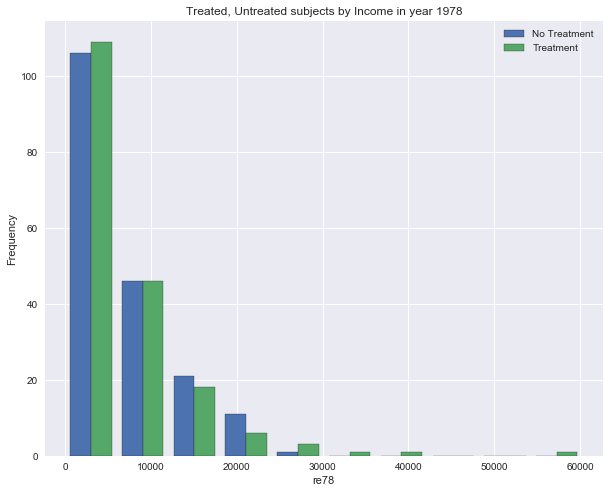

Satistics of Untreated subjects by Income in year 1978

count      185.000000
mean      5828.584903
std       6094.306306
min          0.000000
25%        237.914000
50%       4112.513000
75%       8957.978000
max      25564.670000
Name: re78, dtype: float64


Satistics of Treated subjects by Income in year 1978

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


In [37]:
earnings = ['re78']
for e in earnings:
    title = 'Income in year 19{}'.format(e[2:])
    compare_distributions(untreated_matched, treated_matched, e, title)

Then, compare the feature-value distributions between the two groups, as we've done in part 2.

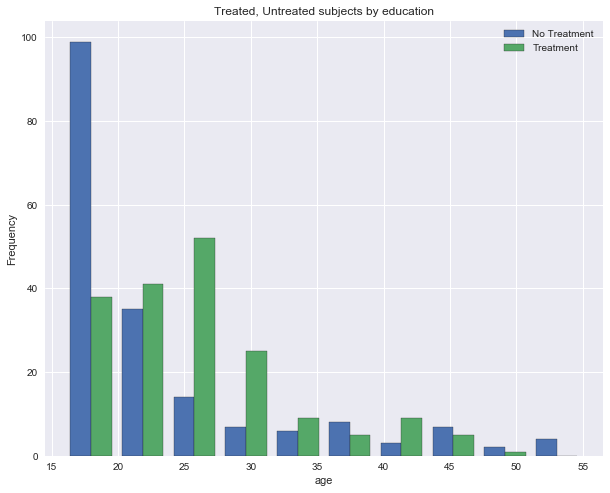

Satistics of Untreated subjects by education

count    185.000000
mean      23.167568
std        9.337805
min       16.000000
25%       17.000000
50%       19.000000
75%       24.000000
max       55.000000
Name: age, dtype: float64


Satistics of Treated subjects by education

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64


In [38]:
compare_distributions(untreated_matched, treated_matched, 'age', 'education')

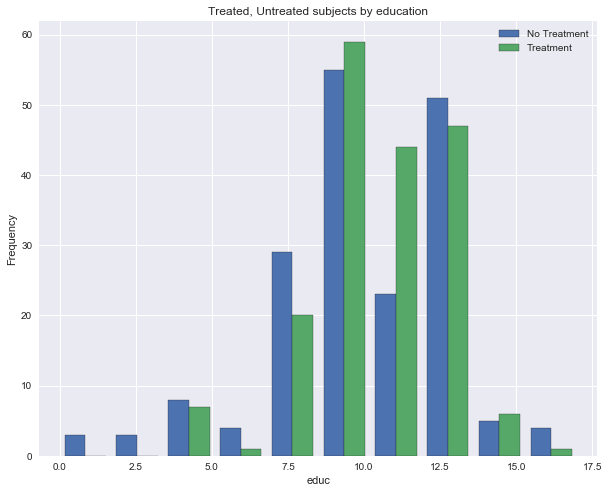

Satistics of Untreated subjects by education

count    185.000000
mean       9.864865
std        2.775692
min        0.000000
25%        8.000000
50%       10.000000
75%       12.000000
max       17.000000
Name: educ, dtype: float64


Satistics of Treated subjects by education

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64


In [39]:
compare_distributions(untreated_matched, treated_matched, 'educ', 'education')

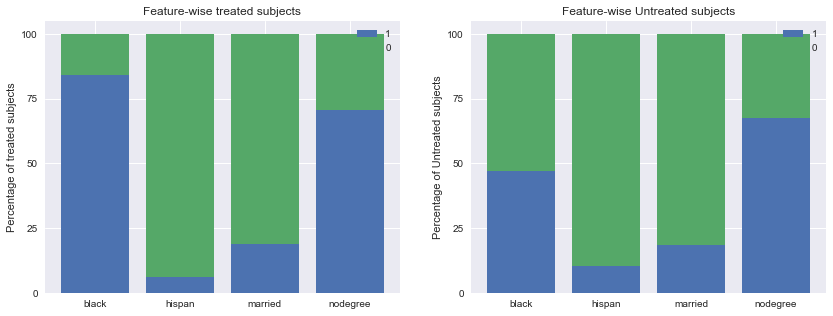

In [40]:
compare_feature_value(treated_matched, untreated_matched)

As we can see from these figures, matches were (almost) reasonably accurate. 
What we can derive from these results is that balancing the data reveal that the treatment seems effective since the mean value 're78' (income level) is more in treated group. This is the oppostive of what we've observed before balancing the groups. However, we need to do more analysis (e.g. balance 'black' variable between groups) to make sure that this inference is true but we are clearly, closer to being able to draw valid conclusions now than before.

## `(1)(5) Balancing the Groups Further`

Let's look closer into our new DataFrame and see if it's balanced.

In [41]:
balanced = treated_matched.append(untreated_matched)

In [42]:
balanced.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_0,prop_1
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,0.500000,24.491892,10.105405,0.656757,0.081081,0.186486,0.691892,2181.979934,1601.096992,6088.864217,0.533536,0.466464
std,0.500677,8.412224,2.432219,0.475435,0.273329,0.390026,0.462337,4581.758779,2983.674365,7032.213485,0.237978,0.237978
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114378,0.036175
25%,0.000000,18.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,322.999875,0.311395,0.206591
50%,0.500000,22.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,132.483850,4207.125500,0.457361,0.542639
75%,1.000000,27.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1932.604250,1955.032250,9344.724750,0.793409,0.688605
max,1.000000,55.000000,17.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,0.963825,0.885622


Out of our matched set, we saw that the black feature was problematic, so in order to get a more accurate match, so we filter our previous match, and take only the matches that have the same *black* attribute

In [43]:
a = treated_matched.index
b = untreated_matched.index
idx = []
for i in range(len(a)):
    if treated_matched.loc[a[i]].black == untreated_matched.loc[b[i]].black:
        idx.append(a[i])
        idx.append(b[i])
black_balanced = treated_matched.append(untreated_matched).loc[idx]

In [44]:
black_balanced.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_0,prop_1
id,,,,,,,,,,,,
NSW10,1,33,12,0,0,1,0,0.000,0.0000,12418.070,0.913265,0.086735
PSID394,0,34,8,0,0,1,1,0.000,0.0000,2664.341,0.913108,0.086892
NSW100,1,31,9,0,1,0,1,0.000,0.0000,26817.600,0.787110,0.212890
PSID221,0,19,12,0,0,0,0,815.055,964.9839,12059.730,0.795650,0.204350
NSW102,1,26,10,1,0,0,1,0.000,0.0000,9265.788,0.294593,0.705407


In [45]:
black_balanced_treated = black_balanced[black_balanced['treat']== 1]
black_balanced_untreated = black_balanced[black_balanced['treat']== 0]

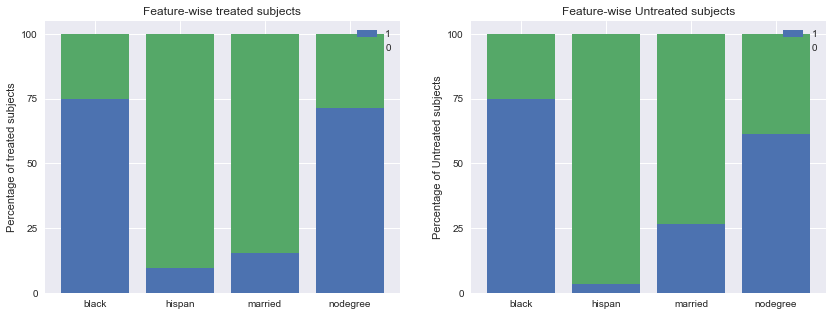

In [46]:
compare_feature_value(black_balanced_treated, black_balanced_untreated)

Now as we can see from the barplots, the black attribute is perfectly balanced.

We do the same operation for the varible 'married', in order to balance the data more.

In [47]:
a = black_balanced_treated.index
b = black_balanced_untreated.index
idx = []
for i in range(len(a)):
    if black_balanced_treated.loc[a[i]].married == black_balanced_untreated.loc[b[i]].married:
        idx.append(a[i])
        idx.append(b[i])
married_balanced = black_balanced_treated.append(black_balanced_untreated).loc[idx]

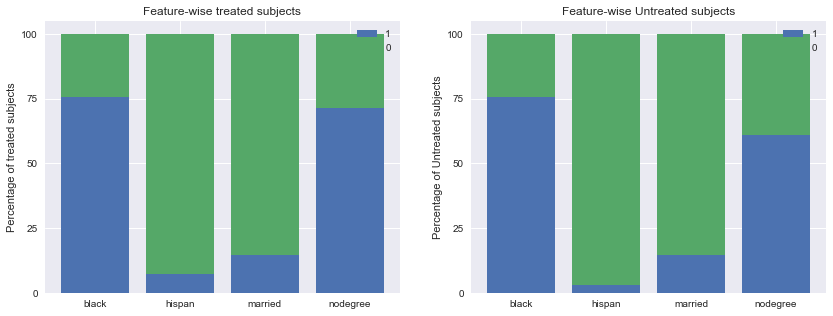

In [48]:
married_balanced_treated = married_balanced[married_balanced['treat']== 1]
married_balanced_untreated = married_balanced[married_balanced['treat']== 0]
compare_feature_value(married_balanced_treated, married_balanced_untreated)

We now can say that, (almost) all variables are balanced among groups. Atleast, it is much better then after part 4.

## `(1)(6) A Less Naive Analysis`

In [49]:
r78_treated_final = married_balanced_treated['re78']
r78_untreated_final = married_balanced_untreated['re78']

**Kolmogorov-Smirnov Test**

In [50]:
stats.ks_2samp(black_balanced_treated['re78'], black_balanced_untreated['re78'])

Ks_2sampResult(statistic=0.17241379310344829, pvalue=0.056248685396704676)

$p-value \geqslant 0.05$ so, there is again, a difference betwen distribtuion of the variable 're78' between two groups. But this time we expect the mean value of 'r78' variable (that is avarege income) to be higher for tretated group (and not vice-versa as we found with naive analysis in part 1-2).

**Visual Comparison**

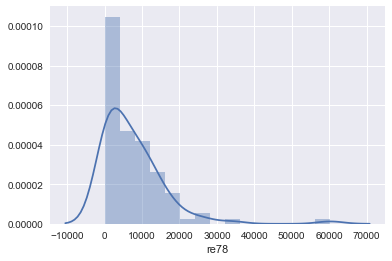

In [51]:
sns.distplot(r78_treated_final)

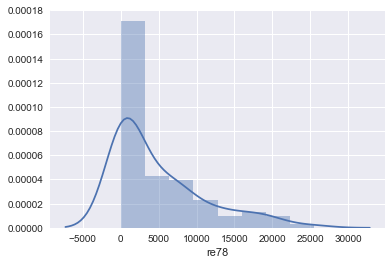

In [52]:
sns.distplot(r78_untreated_final)

In [53]:
r78_untreated_final.describe()

count       95.000000
mean      4925.884759
std       6087.820128
min          0.000000
25%         15.516130
50%       2281.610000
75%       7609.553000
max      25564.670000
Name: re78, dtype: float64

In [54]:
r78_treated_final.describe()

count       95.000000
mean      7504.387517
std       8771.555434
min          0.000000
25%       1189.924500
50%       5522.788000
75%      10945.110000
max      60307.930000
Name: re78, dtype: float64

From these plots and the stats, it seems that the income of treated group is higher meaning that the **treatment is effective**.

To further analyze the distribution of the variable 'r78' between groups:

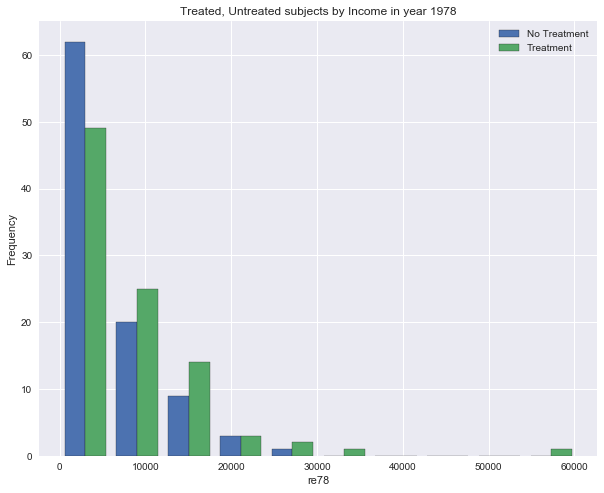

Satistics of Untreated subjects by Income in year 1978

count       95.000000
mean      4925.884759
std       6087.820128
min          0.000000
25%         15.516130
50%       2281.610000
75%       7609.553000
max      25564.670000
Name: re78, dtype: float64


Satistics of Treated subjects by Income in year 1978

count       95.000000
mean      7504.387517
std       8771.555434
min          0.000000
25%       1189.924500
50%       5522.788000
75%      10945.110000
max      60307.930000
Name: re78, dtype: float64


In [55]:
year_variables = ['re78']
for year in year_variables:
    title = 'Income in year 19{}'.format(year[2:])
    compare_distributions(married_balanced_untreated, married_balanced_treated, year, title)

From the the **re78** plot and the numbers, we can conclude that the treatment is effective, as the quantiles are larger **(robust statistics)**.

**To emphasize the findings once more, what we've found with naive analysis in first parts is that the treatment is ineffective but after we've matched the people and balanced the groups we've found that the treatment is actually effective.**

# `2 Applied ML`

## `2(1)`

### `Load the` *`20newsgroup`*  `Dataset`

In [3]:
newsgroup = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

print("%d documents" % len(newsgroup.filenames))
print("%d categories" % len(newsgroup.target_names))

11314 documents
20 categories


### `Compute vectors using TF-IDF scores`

In [4]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroup.data)

print("%d vectors" % len(vectors.todense()))

11314 vectors


### `Pair category of each article`

In [5]:
catregory_ref = dict()
for i,k  in enumerate(newsgroup['target_names']):
    catregory_ref[k] = i

In [6]:
extract_category = lambda filename: catregory_ref[filename.split("/")[6]]
category_func = np.vectorize(extract_category)
category = np.transpose(csr_matrix(category_func(newsgroup['filenames'])))

### `Split the data into train, validation and test sets`

In [7]:
x = vectors
y = category
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.11)

print("%d articles in train dataset" % len(x_train.todense()))
print("%d articles in validation dataset" % len(x_validation.todense()))
print("%d articles in test dataset" % len(x_test.todense()))


9061 articles in train dataset
1121 articles in validation dataset
1132 articles in test dataset


## `2(2)`

In [8]:
def random_forest_accuracy(x_train, y_train, x_validation, y_validation, max_depth, n_estimators):
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
    clf.fit(x_train.todense(), np.ravel(y_train.todense()))
    
    return accuracy_score(y_validation.todense(), clf.predict(x_validation.todense()))

### `Grid search on` *`max_depth`* `and` *`n_estimators`*

In [9]:
n_estimators_list = [70,90,110]
max_depth_list = [70,90,110]

best_param = {'n_estimators': 0,
              'max_depth': 0}

max_acc = 0.

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        acc = random_forest_accuracy(x_train, y_train, x_validation, y_validation, max_depth, n_estimators)
        print("Accuracy = %f for n_estimators = %d, max_depth = %d"%(acc,n_estimators,max_depth))
        if acc > max_acc:
            max_acc = acc
            best_param['n_estimators'] = n_estimators
            best_param['max_depth'] = max_depth

print('The best accuracy score %f is obtained by parameters %s.'%(max_acc,str(best_param)))

Accuracy = 0.640500 for n_estimators = 70, max_depth = 70
Accuracy = 0.623550 for n_estimators = 70, max_depth = 90
Accuracy = 0.617306 for n_estimators = 70, max_depth = 110
Accuracy = 0.631579 for n_estimators = 90, max_depth = 70
Accuracy = 0.638715 for n_estimators = 90, max_depth = 90
Accuracy = 0.649420 for n_estimators = 90, max_depth = 110
Accuracy = 0.633363 for n_estimators = 110, max_depth = 70
Accuracy = 0.647636 for n_estimators = 110, max_depth = 90
Accuracy = 0.647636 for n_estimators = 110, max_depth = 110
The best accuracy score 0.649420 is obtained by parameters {'n_estimators': 90, 'max_depth': 110}.


##  `Alternative method to find best parameters using` *`scikit-learn`*

### `Load the` *`20newsgroup`*  `Dataset`

In [15]:
newsgroup = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

print("%d documents" % len(newsgroup.filenames))
print("%d categories" % len(newsgroup.target_names))

11314 documents
20 categories


### `Create pipeline with` *`TfidfVectorizer()`* `and` *`RandomForestClassifier()`*

In [10]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier()),
])

### `Grid search on` *`max_depth`* `and` *`n_estimators`*

`Here, validation dataset is not required since` **`cross-validation`** `is used to calculate the accuarcy of the model.`
`What cross-validation does is that it divides the train dataset into chunks and use all of these chunks expect one to train model then it uses the remaining one chunk to calculate accuracy. This process is repeated for each of theese chunks and avarage accuracy is reported.`

In [17]:
parameters = {
    'clf__n_estimators': (70, 90, 110),
    'clf__max_depth': (70, 90, 110),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(newsgroup.data, newsgroup.target)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.1min finished


Best score: 0.637
Best parameters set:
	clf__max_depth: 110
	clf__n_estimators: 110


`Note that this method give the optimal` *`max_depth`* `as 110 comparing to 90. This is acceptable since with both of these value, calculated accuracy is highly similar and therefore, it is reasonable to train the Random Forest model with either of them.` 

### `Train the model with best parameters`

In [19]:
clf = RandomForestClassifier(max_depth=90, n_estimators=110)
clf.fit(x_train.todense(), np.ravel(y_train.todense()))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### `Display a confusion matrix`

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

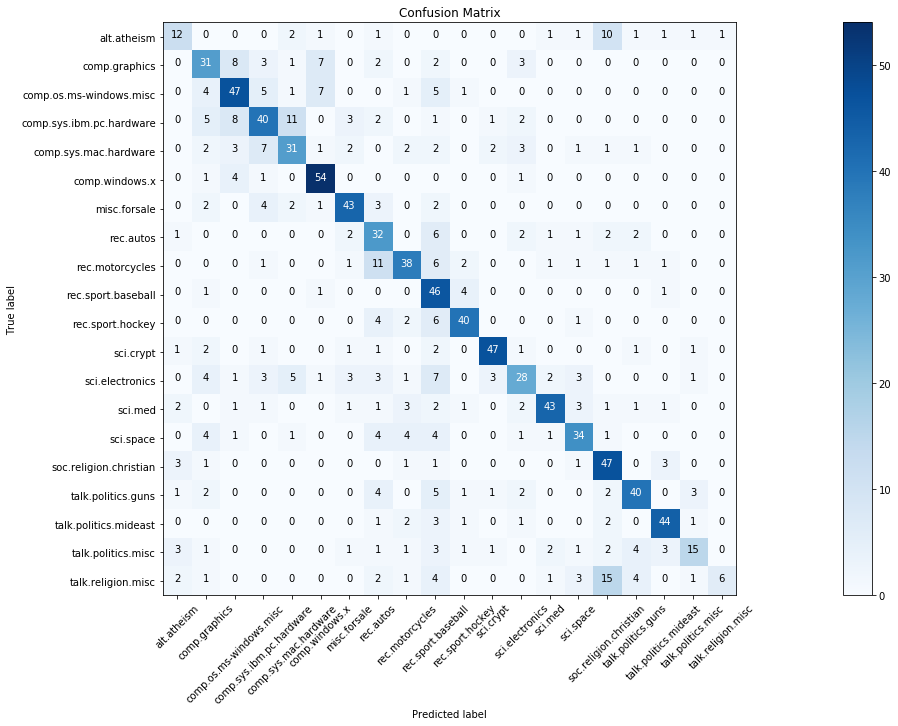

In [21]:
cnf_matrix = confusion_matrix(y_validation.todense(), clf.predict(x_validation.todense()))
np.set_printoptions(precision=2)

plt.figure(figsize=(30,10))
plot_confusion_matrix(cnf_matrix, classes=newsgroup.target_names, title='Confusion Matrix')

`From confusion matrix precision an recall values can be derived for each class.`
`For instance these values for` **`graphics`** `class is as follows.`

$recall = \frac{Number of True Positives}{Number of Actual Graphics} = \frac{31}{57} = 0.543$

$precision = \frac{Number of True Positives}{Number of Predicted Graphics} = \frac{31}{61} = 0.508$

### `Inspect the` *`feature_importances`*  `attribute of the Random Forest model`

In [22]:
n_01 = 0
n_001 = 0
n_0001 = 0
n_00001 = 0
n_000001 = 0

for i in np.array(clf.feature_importances_):
    if i > 0.001:
        n_001 += 1
    if i > 0.0001:
        n_0001 += 1
    if i > 0.00001:
        n_00001 += 1
    if i > 0.000001:
        n_000001 += 1

In [23]:
print('There are %d TF-IDF features in total'%len(clf.feature_importances_))
print('%d of them bigger than 0.01'%n_01)
print('%d of them bigger than 0.001'%n_001)
print('%d of them bigger than 0.0001'%n_0001)
print('%d of them bigger than 0.00001'%n_00001)
print('%d of them bigger than 0.000001'%n_000001)
print('And %d of them smaller than 0.000001'%(len(clf.feature_importances_)-n_000001))

There are 101631 TF-IDF features in total
0 of them bigger than 0.01
145 of them bigger than 0.001
1738 of them bigger than 0.0001
9257 of them bigger than 0.00001
25331 of them bigger than 0.000001
And 76300 of them smaller than 0.000001


`As it can be derived from these values, most of the features are not hold significant weights. Only 149 out of 101.631 features (that are words) have an noticable impact on the model while predicting class. This can be interpreted as follows. There are only number of words that is actually (highly) distinguishing for classes and most of the words are just words that doesn't really give information about the class of the article. It is highly possible that most of such words are just stop words and not really domain specific (e.g. the, a, an, I, am, he, she, they, in, on, between). On the other hand, the most significant 149 words should be words that are highly realted to the classes of articles (e.g. drive, BMW, Mercedes, speed, road).`